<h1>Analysis of Distribution of Merchant Fraud Data<h1>

In [1]:
# Import packages and start spark session

from pyspark.sql import SparkSession, functions as F, DataFrame
from pyspark.sql.functions import isnan, when, count, col
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
import pandas as pd

spark = (
    SparkSession.builder.appName("Merchant Fraud Analysis")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

22/09/19 15:40:38 WARN Utils: Your hostname, Jacks-MacBook-Air-2.local resolves to a loopback address: 127.0.0.1; using 10.12.225.158 instead (on interface en0)
22/09/19 15:40:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/19 15:40:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/09/19 15:40:39 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
# Read in the data
df = spark.read.parquet('../data/curated/merchant_fraud.parquet/')
df.show(1, vertical = True)
df.count()

-RECORD 0---------------------------------
 merchant_abn        | 38700038932        
 order_datetime      | 2021-08-20         
 transaction_count   | 14                 
 avg_transaction_amt | 1524.9292206627556 
 is_fraud            | false              
 fraud_probability   | 0.01               
only showing top 1 row



1344515

In [3]:
# Sample overall dataset to improve visualisation. This is done to improve visualisation and decrease cluttering

pdf = df.toPandas()
pdf["is_fraud"] = pdf["is_fraud"].astype(int)
pdf['order_datetime'] = pd.to_datetime(pdf['order_datetime'])
pdf['day_of_week'] = pdf['order_datetime'].dt.day_name()
# Stratefied to get an even number of fraud and non-fraud cases. Even number allows for stronger comparison

pdf_fraud = pdf.loc[pdf['is_fraud'] == 1]
pdf_nfraud = pdf.loc[pdf['is_fraud'] == 0]

pdf_nfraud_sample = pdf_nfraud.sample(frac=pdf_fraud.size/(pdf_fraud.size+pdf_nfraud.size), random_state = 111)

sample_pdf = pdf_fraud.append(pdf_nfraud_sample)

/var/folders/ck/psrltvd10474n3pnlfszjw500000gn/T/ipykernel_20200/925136834.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample_pdf = pdf_fraud.append(pdf_nfraud_sample)


Text(0, 0.5, 'Average Amount')

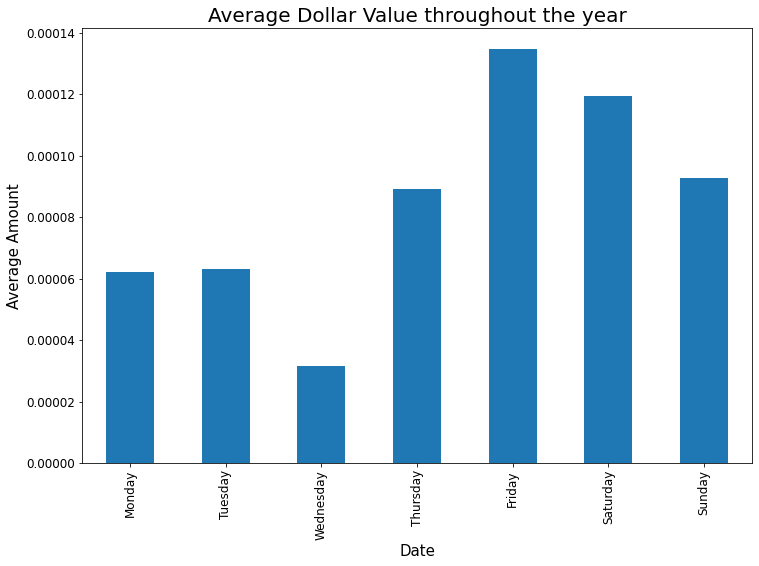

In [4]:
day_of_week_df = pdf[['day_of_week', 'is_fraud']] \
                .groupby('day_of_week') \
                .agg(
                    {
                        'is_fraud': 'sum', 
                        'day_of_week': 'count'
                    }
                )
day_of_week_df['percent'] = day_of_week_df['is_fraud']/day_of_week_df['day_of_week']
day_of_week_df.rename(columns={'day_of_week': "count"}, inplace=True)
day_of_week_df = day_of_week_df.reset_index()
dotw = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_of_week_df['day_of_week'] = pd.Categorical(day_of_week_df['day_of_week'], categories=dotw, ordered=True)
day_of_week_df = day_of_week_df.sort_values('day_of_week')

x = day_of_week_df['day_of_week']
y = day_of_week_df['percent']

# plotting
fig, ax = plt.subplots(figsize=(12,8))
time_df = pd.DataFrame({"day_of_week": x, "percent":y})
time_df.plot(kind='bar', x= 'day_of_week', y= 'percent', fontsize = 12, ax=ax, legend = False) 
ax.set_title('Average Dollar Value throughout the year', fontsize = 20)
ax.set_xlabel("Date", fontsize = 15)
xticks = ax.get_xticks()
ax.set_ylabel("Average Amount", fontsize = 15)


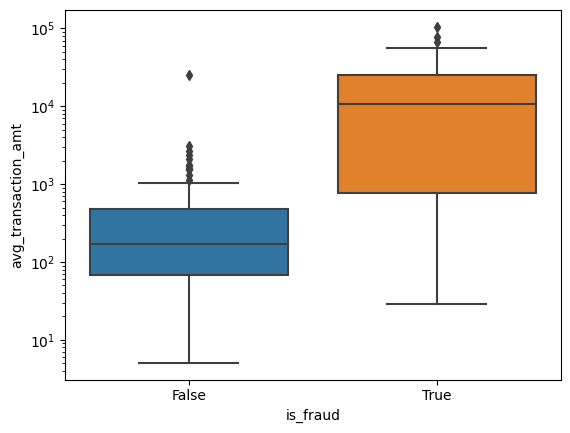

In [85]:
sns.boxplot(y='avg_transaction_amt', x='is_fraud', data=sample_pdf).set_yscale('log')

Average transaction value for merchant workdays labelled as fraudulent is consistently larger than those labelled as non-fraudulent, indicating this could be an indicator towards fraudulent activity

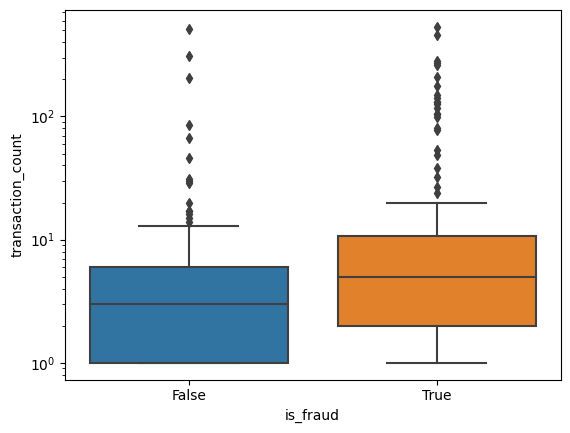

In [86]:
sns.boxplot(y='transaction_count', x='is_fraud', data=sample_pdf).set_yscale('log')

The difference is not as blatant, but days with potential fraudulent activity do tend to see a larger number of transactions, again indicating that increased number of transactions could mean fraudulent activity

In [145]:
# Calculate percentage of each merchant's transactions that may be considered fraud

fraud_counts = pdf_fraud.groupby(by = ['merchant_abn'], sort = True).agg({'transaction_count': 'sum'}).rename(columns = {'transaction_count':'fraudulent_transactions'})
non_fraud_counts = pdf_nfraud.groupby(by = ['merchant_abn']).agg({'transaction_count':'sum'}).rename(columns = {'transaction_count':'non_fraudulent_transactions'})

fraud = fraud_counts.join(non_fraud_counts, how = "outer")
fraud = fraud.fillna(0)
fraud['fraud_percentage'] = 100*fraud['fraudulent_transactions']/(fraud['non_fraudulent_transactions']+fraud['fraudulent_transactions'])

# Count number of merchants that have 0% fraudulent transactions

print("Number of merchants with no fraud: " + str(len(fraud.loc[fraud['fraud_percentage'] == 0]))) 
print("Number of merchants with some fraud: " + str(len(fraud.loc[fraud['fraud_percentage'] > 0])))

Number of merchants with no fraud: 4361
Number of merchants with some fraud: 61


There are enough merchants that have no fraud that it would be reasonable to completely avoid dealing with fraudulent merchants

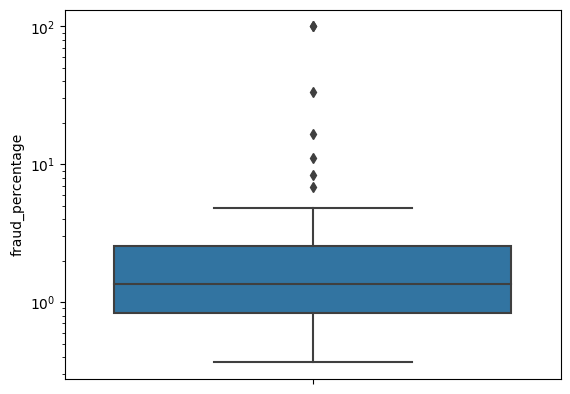

In [144]:
# Plot percentage of fraud transactions for those merchants that have some fraud

sns.boxplot(y='fraud_percentage', data=fraud.loc[fraud['fraud_percentage'] > 0]).set_yscale('log')

<h1>Analysis of Distribution of Consumer Fraud Data<h1>

In [5]:
# Read in the data
df = spark.read.parquet('../data/curated/consumer_fraud.parquet/')
df.show(1, vertical = True)
df.count()

-RECORD 0-------------------------------
 user_id             | 18487            
 order_datetime      | 2021-08-20       
 transaction_count   | 2                
 avg_transaction_amt | 73.0925761125627 
 is_fraud            | false            
 fraud_probability   | 0.01             
only showing top 1 row



8977056

In [6]:
# Sample overall dataset to improve visualisation. This is done to improve visualisation and decrease cluttering
pdf = df.toPandas()
pdf["is_fraud"] = pdf["is_fraud"].astype(int)
pdf['order_datetime'] = pd.to_datetime(pdf['order_datetime'])
pdf['day_of_week'] = pdf['order_datetime'].dt.day_name()
# Stratefied to get an even number of fraud and non-fraud cases. Even number allows for stronger comparison

pdf_fraud = pdf.loc[pdf['is_fraud'] == 1]
pdf_nfraud = pdf.loc[pdf['is_fraud'] == 0]

pdf_nfraud_sample = pdf_nfraud.sample(frac=pdf_fraud.size/(pdf_fraud.size+pdf_nfraud.size), random_state = 111)

sample_pdf = pdf_fraud.append(pdf_nfraud_sample)

In [ ]:
day_of_week_df = pdf[['day_of_week', 'is_fraud']] \
                .groupby('day_of_week') \
                .agg(
                    {
                        'is_fraud': 'sum', 
                        'day_of_week': 'count'
                    }
                )
day_of_week_df['percent'] = day_of_week_df['is_fraud']/day_of_week_df['day_of_week']
day_of_week_df.rename(columns={'day_of_week': "count"}, inplace=True)
day_of_week_df = day_of_week_df.reset_index()
dotw = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_of_week_df['day_of_week'] = pd.Categorical(day_of_week_df['day_of_week'], categories=dotw, ordered=True)
day_of_week_df = day_of_week_df.sort_values('day_of_week')

x = day_of_week_df['day_of_week']
y = day_of_week_df['percent']

# plotting
fig, ax = plt.subplots(figsize=(12,8))
time_df = pd.DataFrame({"day_of_week": x, "percent":y})
time_df.plot(kind='bar', x= 'day_of_week', y= 'percent', fontsize = 12, ax=ax, legend = False) 
ax.set_title('Average Dollar Value throughout the year', fontsize = 20)
ax.set_xlabel("Date", fontsize = 15)
xticks = ax.get_xticks()
ax.set_ylabel("Average Amount", fontsize = 15)

In [ ]:
sns.boxplot(y='avg_transaction_amt', x='is_fraud', data=sample_pdf).set_yscale('log')

In [ ]:
sns.boxplot(y='transaction_count', x='is_fraud', data=sample_pdf).set_yscale('log')

In [ ]:
# Calculate percentage of each users's transactions that may be considered fraud

fraud_counts = pdf_fraud.groupby(by = ['user_id'], sort = True).agg({'transaction_count': 'sum'}).rename(columns = {'transaction_count':'fraudulent_transactions'})
non_fraud_counts = pdf_nfraud.groupby(by = ['user_id']).agg({'transaction_count':'sum'}).rename(columns = {'transaction_count':'non_fraudulent_transactions'})

fraud = fraud_counts.join(non_fraud_counts, how = "outer")
fraud = fraud.fillna(0)
fraud['fraud_percentage'] = 100*fraud['fraudulent_transactions']/(fraud['non_fraudulent_transactions']+fraud['fraudulent_transactions'])

# Count number of users that have 0% fraudulent transactions

print("Number of users with no fraud: " + str(len(fraud.loc[fraud['fraud_percentage'] == 0]))) 
print("Number of users with some fraud: " + str(len(fraud.loc[fraud['fraud_percentage'] > 0])))

In [ ]:
# Plot percentage of fraud transactions for those users that have some fraud

sns.boxplot(y='fraud_percentage', data=fraud.loc[fraud['fraud_percentage'] > 0]).set_yscale('log')